### INSTALL AND IMPORT DEPENDENCIES

In [1]:
# !pip install git+https://github.com/GabrieleSgroi/genetic_algorithm
# !pip install gym[all]
# !pip install ufal.pybox2d
# !pip install gymnasium
# !pip install pygame
# !pip install  pyvirtualdisplay
# !pip install box2d-py

import os
import numpy as np
import genetic_alg
from genetic_alg.ga import GeneticAlg
from genetic_alg.mutations import gaussian_mutation
from genetic_alg.crossovers import single_point_crossover
from genetic_alg.selections import rank_selection, boltzmann_selection
from genetic_alg.utils import flatten_weights, reshape_weights
import IPython
import pyvirtualdisplay
import base64
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Lambda
# Set up a virtual display for rendering OpenAI gym environments.
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
env = gym.make("LunarLanderContinuous-v3", render_mode='rgb_array')
print(env.action_space)
print(env.observation_space)

Box(-1.0, 1.0, (2,), float32)
Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [2]:
#Function to load the saved model
def load_ga(dir, fitness_fn, mutation_fn, crossover_fn,
                 selection_fn, keep_parents=0, callback=None):
    '''Returns the loaded GeneticAlg instance'''
    loaded=GeneticAlg([], fitness_fn, mutation_fn, crossover_fn,
                 selection_fn, keep_parents=0, callback=callback)
    loaded.population=np.load(dir+'saved_model/population.npy' ).tolist()
    loaded.fitness=np.load(dir+'saved_model/fitness.npy' ).tolist()
    loaded.num_generations=np.load(dir+'saved_model/generation.npy')
    loaded.fitness_hist=np.load(dir+'saved_model/hist.npy').tolist()
    loaded.best_fitness=np.load(dir+'saved_model/best_fitness.npy')
    loaded.best_solution=np.load(dir+'saved_model/best_sol.npy')
    
    return loaded

EVALUATION UTILITIES

In [3]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, env, filename, num_episodes=3, fps=30):
  '''Create a video of the given policy'''
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      terminated = False
#       print(env.reset())
      obs= np.asarray(env.reset()[0])
#       print(obs)
      # obs=np.expand_dims(obs, axis=0)
      obs = obs.reshape(1, -1)
      obs = tf.convert_to_tensor(obs, dtype=tf.float32)
      video.append_data(env.render())
      reward=0
      frame_counter=0
      while not terminated:
        if filename == "random.mp4":
           action = policy.predict(obs)[0]
        else:
          action=policy.predict(obs, verbose=0)[0]
        obs, rew, terminated, truncated, info = env.step(action)
#         print(obs, rew, terminated, truncated, info)
        reward+=rew
        # obs=np.expand_dims(np.array(obs), axis=0)
        video.append_data(env.render())
        frame_counter+=1
      print('Episode reward:', reward, 'Number of frames:', frame_counter)
  return embed_mp4(filename)

Performance of model in which the agent acts randomly

In [4]:
class RandomModel():
    '''Creates a model that takes random action'''
    def __init__(self, action_dim):
        self.dim=action_dim

    def predict(self, data):
        rand=np.random.uniform(range(self.dim))
        return [rand]

rand_model=RandomModel(2)
create_policy_eval_video(rand_model, env, 'random', num_episodes=5)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode reward: -1127.3038275658566 Number of frames: 100
Episode reward: -750.6662200841268 Number of frames: 80
Episode reward: -1247.3533775664655 Number of frames: 95
Episode reward: -1384.8393559670085 Number of frames: 111
Episode reward: -1353.4437738405152 Number of frames: 110


## Genetic algorithm functions

In [5]:
def mutation_fn(sol):
    return gaussian_mutation(sol,mutation_rate=0.1, std=0.1)

def crossover_fn(sol):
    return single_point_crossover(sol, crossover_p=0.5)

def fit_func(sol):
    fitness=0
    model.set_weights(reshape_weights(model,sol))
    for i in range(1):
        obs=env.reset()[0]
        terminated = False
        truncated = False
        while not terminated and not truncated:
            obs=np.expand_dims(obs, axis=0)
            action=model.predict(obs, verbose=0)[0]
            obs, rew, terminated, truncated, info= env.step(action)
            fitness+=rew
    return fitness

def selection_fn(fitness):
    #Normalize fitnesses before passing to exponential, this will avoid scale dependence
    fitness=(fitness-np.mean(fitness))/(np.std(fitness))
    return boltzmann_selection(fitness, T=1.)

def generate_initial_pop(pop_size):
    models=[]
    initial_pop=[]
    for i in range(pop_size):
        inp=Input((8,))
        x=inp
        for i in range(2):
            x=Dense(256, activation='tanh')(x)
        out=Dense(2, activation='tanh')(x)
        models.append(Model(inputs=inp, outputs=out, trainable=False))
        initial_pop.append(flatten_weights(models[-1]))
    return initial_pop, models[-1]


def T_scheduler(inst):
    n_gen=inst.num_generations
    T=max(3*2**(-n_gen/50), 0.3)
    def selection_fn(fitness):
    #Normalize fitnesses before passing to exponential, this will avoid scale dependence
        fitness=(fitness-np.mean(fitness))/(np.std(fitness))
        return boltzmann_selection(fitness, T=T)
    inst.selection_fn=selection_fn
    print('Temperature for Boltzmann selection', T)

def save_call(inst):
    inst.save(save_path) #save and log every generation

# Training Loop

Training loop with automatic resuming previous run.

In [6]:
save_path = ''

In [7]:
# generations_run=50

# def save_video_call(inst):
#     n_gen=inst.num_generations
#     if n_gen % 50==0:
#         if not os.path.exists(save_path+'/videos'):
#             os.makedirs(save_path+'/videos')
#         idx=np.argmax(inst.fitness)
#         current_best=inst.population[idx]
#         model.set_weights(reshape_weights(model,current_best))
#         create_policy_eval_video(model, env, save_path+'/videos/'+str(n_gen), num_episodes=5)
#         print('')

# if os.path.exists(save_path+'/saved_model'):
#     unused, model=generate_initial_pop(50)
#     ga=load_ga(save_path, fit_func, mutation_fn, crossover_fn, None, keep_parents=5, callback=[save_video_call,T_scheduler, save_call])
#     n_gen=ga.num_generations
#     T=max(3*2**(-n_gen/50), 0.3)    #Set selection function with the right temperature
#     def selection_fn(fitness):
#         fitness=(fitness-np.mean(fitness))/(np.std(fitness))
#         return boltzmann_selection(fitness, T=T)
#     ga.selection_fn=selection_fn
#     print('Num parameters:', len(ga.population[0]))
#     ga.run(generations_run)

# else:
#     initial_pop, model=generate_initial_pop(50)
#     print('Num parameters:', len(initial_pop[0]))
#     ga=GeneticAlg(initial_pop, fit_func, mutation_fn, crossover_fn, selection_fn, keep_parents=5, callback=[save_video_call, T_scheduler, save_call])
#     ga.run(generations_run)

# ga.save(save_path)

### Result visualization

Polulation mean and standard deviation through generations

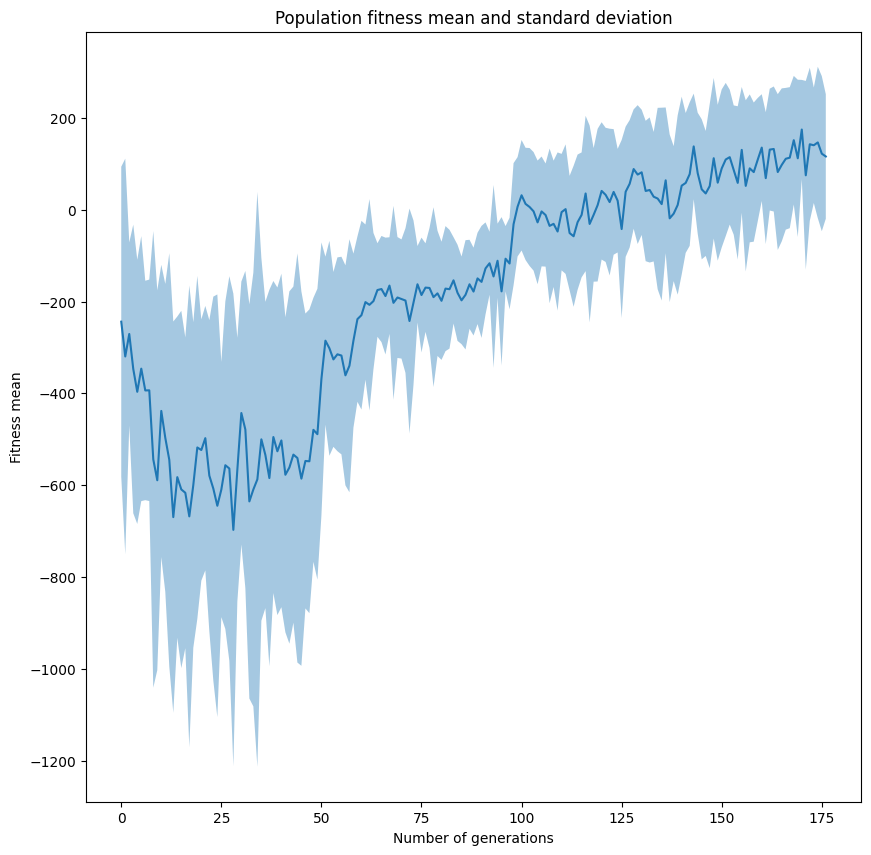

In [8]:
save_path=''
initial_pop, model=generate_initial_pop(1)
ga=load_ga(save_path, fit_func, mutation_fn, crossover_fn, selection_fn, keep_parents=5)

fit_mean=[]
fit_std=[]
for el in ga.fitness_hist:
    fit_mean.append(el[2])
    fit_std.append(el[3])

fit_mean=np.array(fit_mean)
fit_std=np.array(fit_std)
plt.figure(figsize=(10,10))
plt.plot(fit_mean)
plt.fill_between(list(range(len(fit_mean))), fit_mean-fit_std, fit_mean+fit_std, alpha=0.4)
plt.savefig(save_path+'/pop_fitness.png')
plt.ylabel('Fitness mean')
plt.xlabel('Number of generations')
plt.title('Population fitness mean and standard deviation')
plt.show()

Best solution of the population at each epoch.

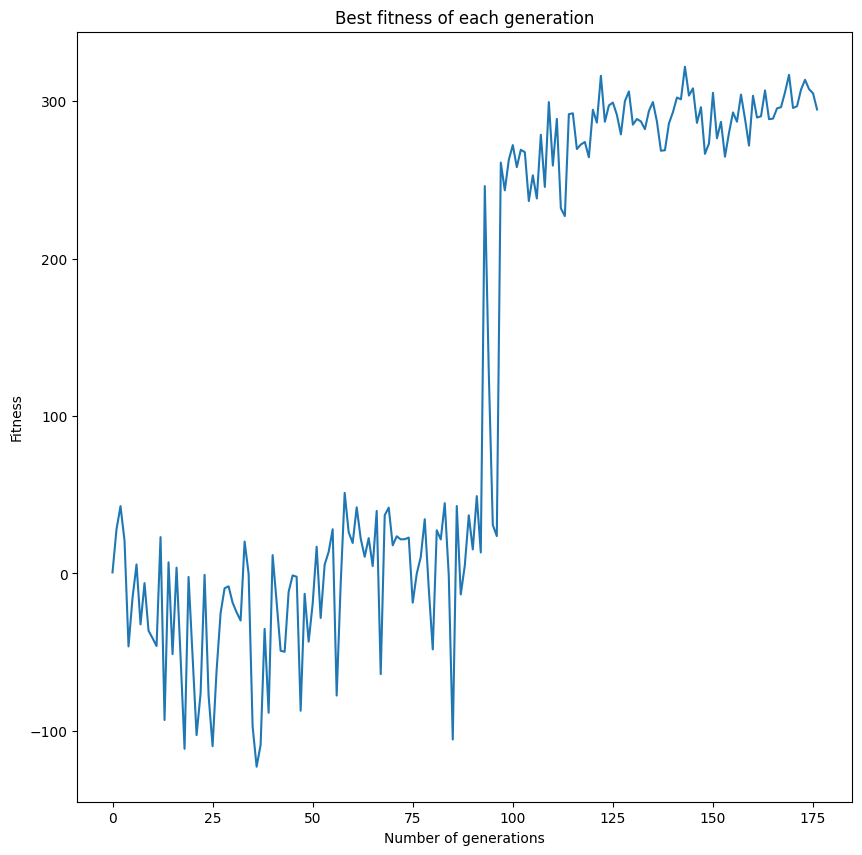

In [9]:
current_best=[]

for el in ga.fitness_hist:
    current_best.append(el[1])

plt.figure(figsize=(10,10))
plt.plot(current_best)
plt.title('Best fitness of each generation')
plt.xlabel('Number of generations')
plt.ylabel('Fitness')
plt.show()

Performance of the best solution of the last epoch.

In [10]:
def create_policy_eval_video(policy, env, filename, num_episodes=3, fps=30):
  '''Create a video of the given policy'''
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      terminated = False
      truncated = False
      obs= np.asarray(env.reset()[0])
      obs=np.expand_dims(obs, axis=0)
      video.append_data(env.render())
      reward=0
      frame_counter=0
      while not terminated:
        if filename == "random.mp4":
           action = policy.predict(obs)[0]
        else:
          action=policy.predict(obs, verbose=0)[0]
        obs, rew, terminated, truncated, info = env.step(action)
        obs = np.expand_dims(np.asarray(obs), axis=0)
        reward+=rew
        video.append_data(env.render())
        frame_counter+=1
      print('Episode reward:', reward, 'Number of frames:', frame_counter)
  return embed_mp4(filename)

In [12]:
#Current best solution
idx=np.argmax(ga.fitness)
current_best=ga.population[idx]
model.set_weights(reshape_weights(model,current_best))
create_policy_eval_video(model, env, save_path+'videos/'+str(ga.num_generations), num_episodes=5)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode reward: 276.0353931515408 Number of frames: 194
Episode reward: 273.93478904973347 Number of frames: 324
Episode reward: 238.9052384717866 Number of frames: 340
Episode reward: 277.21887736356064 Number of frames: 341
Episode reward: 240.46725017096665 Number of frames: 356


In [13]:
def evaluate_policy(policy, env, num_episodes=100):
     '''Evaluate the policy. Returns two lists containing episode rewards and
        episode number of frames'''
     rews=[]
     frames=[]
     success_count = 0
     for i in range(num_episodes):
        reward=0
        frame_counter=0
        terminated = False
        obs= np.asarray(env.reset()[0])
        obs=np.expand_dims(obs, axis=0)
        while not terminated:
            action=policy.predict(obs, verbose=0)[0]
            obs, rew, terminated, truncated, info = env.step(action)
            reward+=rew
            obs=np.expand_dims(np.array(obs), axis=0)
            frame_counter+=1
        print('Episode reward:', reward, 'Number of frames:', frame_counter)
        rews.append(reward)
        frames.append(frame_counter)
        if reward >= 200:
            success_count += 1
     return rews, frames, success_count/num_episodes

In [18]:
reward, frames, success_rate=evaluate_policy(model, env, num_episodes=100)
reward_mean=np.mean(reward)
frames_mean=np.mean(frames)
print('Average reward in 100 episodes {}, average number of frames per episode {}'.format(reward_mean, frames_mean))
print(f"Success Rate: {success_rate}")

Episode reward: 266.43497823397024 Number of frames: 307
Episode reward: 279.4009845718038 Number of frames: 353
Episode reward: 240.25015869590686 Number of frames: 893
Episode reward: 277.0213114159404 Number of frames: 362
Episode reward: 218.79161382085303 Number of frames: 361
Episode reward: 290.65020644063776 Number of frames: 523
Episode reward: 248.2278573026654 Number of frames: 376
Episode reward: 245.2343298460101 Number of frames: 361
Episode reward: 248.25938451271386 Number of frames: 377
Episode reward: 231.24540891518913 Number of frames: 462


KeyboardInterrupt: 

The agent is able to obtain 200+ cumulative reward averaged over 100 episodes, indicating it can handle successfully a variety of situations.

Let's visualize the performance of the best solution found so far.

In [19]:
model.set_weights(reshape_weights(model, ga.best_solution))
create_policy_eval_video(model, env, 'Best_recorded', num_episodes=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[swscaler @ 0x633da00] Warning: data is not aligned! This can lead to a speed loss


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

Let's compare with the solution that has scored the maximum fitness recorded. Notice that, due to the stocasticity of the environment, this will be biased as a high fitness score may be obtained randomly from some favourable initial conditions.

In [20]:
print('Best fitness:', ga.best_fitness)
print('Best fitness found at generation', np.argmax(ga.fitness_hist))

Best fitness: 224.9833171521093
Best fitness found at generation 167


In [ ]:
reward, frames=evaluate_policy(model, env, num_episodes=100)
reward_mean=np.mean(reward)
frames_mean=np.mean(frames)
print('Average reward in 100 episodes {}, average number of frames per episode {}'.format(reward_mean, frames_mean))

Average reward in 100 episodes 160.76838611153005, average number of frames per episode 758.16


As expected, the average performance over 100 episodes is significatively worse than the performance of the best solution of the last generation.